In [1]:
import numpy as np
import scipy
from scipy import special
from scipy import integrate
from scipy import interpolate
from scipy import stats
from scipy import optimize
from numpy.random import default_rng

import time

import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Standardizing some of the font sizes for plots

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams['font.weight'] = 'normal'
plt.rcParams['font.family'] = 'serif'

In [3]:
# Some of Matt's matplotlib style settings

import matplotlib as mpl

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
mpl.rc('axes',edgecolor='k')
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'

In [4]:
# Lighting the torch (pytorch...)
from IPython import display
import sys

sys.path.append("C:\\Users\\ericr\\Desktop\\Rutgers\\research\\density_estimation\\Liouville\\naf\\torchkit")
sys.path.append("C:\\Users\\ericr\\Desktop\\Rutgers\\research\\density_estimation\\Liouville\\naf\\torchkit\\torchkit")
sys.path.append("C:\\Users\\ericr\\Desktop\\Rutgers\\research\\density_estimation\\Liouville\\naf")

import naf
import scipy as sp
import math

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.nn import init

from sklearn.preprocessing import RobustScaler,MinMaxScaler

<h1>Making an NFW halo</h1>

<h2>Important equations:</h2>

mass density $\rho (r)$:
\begin{equation}
\rho (r) = \frac{\rho_o}{\frac{r}{a}\left(1+\frac{r}{a}\right)^2}
\end{equation}

total mass at radius r $M (r)$:
\begin{equation}
M (r) = 4 \pi \rho_o a^3 \left( ln\left(1+\frac{r}{a}\right) - \frac{\frac{r}{a}}{1+\frac{r}{a}}\right)
\end{equation}

potential at radius r $\Phi (r)$:
\begin{equation}
\Phi (r) = -4 \pi G \rho_o a^2 \frac{ln\left(1+\frac{r}{a}\right)}{\frac{r}{a}}
\end{equation}

We can define some distant radius $r_\Delta$ where $\rho (r_\Delta)=\Delta\cdot\rho_c$ where $\rho_c$ is the cosmological critical density and $\Delta$ is some number, usually 200. This radius $r_\Delta$ is usually quite a bit bigger than the scale radius a, and the ratio between these quantities is usually characterized by the "concentration" of the halo:
$c=\frac{r_\Delta}{a}$

<h2>Generating the radial distribution</h2>
The differential bit of mass contained in a shell of thickness dr at radius r is given by:
\begin{equation}
    dM(r) = 4\pi r^2 \rho (r) dr.
\end{equation}

Integrating this differential shell of mass up to some radius tells how much mass in enclosed in a volume up to a certain volume. Dividing by some total mass (defined by the mass enclosed at $r_\Delta$) we now have an idea of what fraction of mass is enclosed up to any radius. This is equivalent to the cumulative distribution function for the radius of tracers in the halo:
\begin{equation}
    \text{CDF(r)} = \frac{M(r)}{M(r_{200})} = \frac{\int_0^r {r'}^2 \frac{\rho0}{\left(\frac{r'}{a}\right)\left(1+\frac{r'}{a}\right)^2} dr'} {\int_0^{r_{200}} {r'}^2 \frac{\rho0}{\left(\frac{r'}{a}\right)\left(1+\frac{r'}{a}\right)^2} dr'}
\end{equation}

We can pick a radius at random, but that will only create a flat probability distribution in r. We need a way to systematic way to encode the bumpiness of the distribution in our random number generation. Since we can explicitly compute the CDF we can sample a better way: inverse transform sampling.

The CDF for the radii of tracers in the halo can be written in terms of nice dimensionless variables:
\begin{equation}
    \text{CDF}(\chi) = \frac{ln(1+c\chi) - \frac{c\chi}{1+c\chi}} {ln(1+c) - \frac{c}{1+c}};\:(0<\chi<1)
\end{equation}

where $\chi=\frac{r}{r_\Delta}$ and $c=\frac{r_\Delta}{a}$ (as previously defined).

<h2>Generating the velocity distribution</h2>
We're assuming a Maxwell-Boltzmann distribution for the speeds of the tracer stars, so we can suppose that the radial velocities of the tracers are given by a one-dimensional MB-distribution such as:
\begin{equation}
    f(v_r) = \left(\frac{m}{2\pi k T}\right)^{1/2} e^{-\frac{mv_r^2}{2kT}}
\end{equation}
The first moment of this distribution is clearly zero (it is even about zero), but its second moment is quite useful. This is given by:
\begin{equation}
    \sigma_{v_r}^2 = \frac{kT}{m}.
\end{equation}
For an NFW profile, the halotools documentation claims that $\sigma_{v_r}^2$ is also given by:
\begin{equation}
    \sigma_{v_r}^2 = V_{virial}^2 \frac{c^2 \chi (1+c \chi)^2}{g(c)} \int_{c\chi}^{\infty} \frac{g(y)}{y^3(1+y)^2}dy.
\end{equation}
Note that this integral sucks, here is it's explicit form:
\begin{equation}
\frac{6 (c\chi+1)^2 (c \chi)^2 \text{Li}_2(-(c \chi))+\pi ^2 (c \chi)^4+3 (c \chi)^4 \log ^2((c \chi)+1)+(c \chi)^4 \log ((c \chi)+1)+2 \pi ^2 (c \chi)^3-7 (c \chi)^3+6 (c \chi)^3 \log ^2((c \chi)+1)-4 (c \chi)^3 \log ((c \chi)+1)+\pi ^2 (c \chi)^2-9 (c \chi)^2+3 (c \chi)^2 \log ^2((c \chi)+1)-((c \chi)+1)^2 (c \chi)^2 \log ((c \chi))-8 (c \chi)^2 \log ((c \chi)+1)-(c \chi)-2 (c \chi) \log ((c \chi)+1)+\log ((c \chi)+1)}{2 (c \chi)^2 ((c \chi)+1)^2}
\end{equation}

The $\text{Li}_2(-(c \chi))$ part is probably the worst, it's the polylog function (of 2nd order, or something). I'm pretty sure a computer could numerically integrate this faster than it could actually evaluate this explicit form, maybe I'll compare them sometime but for now, revel in it's horror. I will numerically integrate to get sigma.

As a quick note, I don't totally understand the argument provided by halotools in deriving this and need to think about it some more.
Some relevant links:

<b>Method in halotools:</b>
https://halotools.readthedocs.io/en/latest/api/halotools.empirical_models.NFWPhaseSpace.html#halotools.empirical_models.NFWPhaseSpace.radial_velocity_dispersion

<b>Explanation from halotools:</b>
https://halotools.readthedocs.io/en/latest/source_notes/empirical_models/phase_space_models/nfw_profile_source_notes.html#modeling-the-nfw-velocity-profile

<b>If there's one obvious failure point in my process to generate the velocity profile, I would guess that it's probably here in how I define these dispersions..</b>

The g function is a real time-saver for most things NFW, defined as:
\begin{equation}
    g(x) = \ln(1+x) - \frac{x}{1+x}.
\end{equation}
Although we ultimately want the speed distribution, we looked at the distribution of radial velocities since we knww how to calculate $\sigma_{v_r}^2$. Now we can relate $\sigma_{v_r}^2$ to temperature T and plug this into the speed-version of the Maxwell-Boltzmann distribution (this is the other potential failure point of my method, but I am still unsure) to get:
\begin{equation}
    f(v) = \left(\frac{m}{2\pi k T}\right)^{3/2}4\pi v^2 e^{-\frac{mv^2}{2kT}} = \left(\frac{1}{2\pi \sigma_{v_r}^2}\right)^{3/2}4\pi v^2 e^{-\frac{v^2}{2 \sigma_{v_r}^2}}.
\end{equation}
Note that $\sigma_{v_r}^2$ must be calculated at each radius, thus the dispersion and the speed distribution is a rather complicated function of radii. We'll need to numerically integrate the definition of $\sigma_{v_r}^2$ every time we want it, and then we have to feed that value into $f(v)$ to get the proper PDF for the tracer speeds.

Once we have the speeds for each tracer (using inverse transform sampling), it's a trivial matter to generate their velocities. We can just pick a direction for each tracer by choosing the pairs of spherical angles at random. Note, the polar angle needs to be picked in a clever way to avoid crowding at the poles. When this is finished, we will have generated the positions of each tracer as well as their velocities, providing us with the full 6D phase space of this NFW halo.

<h2>Validation note</h2>
4/15/21, I've checked all of these equations and I don't think that there are any typos anymore. I still need to see if these distributions generate a phase space distribution that obeys the collisionless Boltzmann equation. Have been struggling to write f down explicitly. I should just need the coordinate space density function and the velocity space distribution function, so hopefully I can figure out how to extract those from what I've derived.

<h2>The Phase Space Distribution Function</h2>
Binney and Tremaine describe a function $f(\textbf{x},\textbf{v},t)$ that satisfies:
\begin{equation}
\int d^3\textbf{x}d^3\textbf{v}\:f(\textbf{x},\textbf{v},t) =1.
\end{equation}
I want to know how I should write f in terms of all of the functions I've already found, such as the probability distribution function for the radius and speed. There are assumptions that I've made about angular distributions for both speed and velocity that also need to be encoded.

I also know that I should be able to write:
\begin{equation}
\nu(\textbf{x}) = \int d^3\textbf{v} \: f(\textbf{x},\textbf{v}).
\end{equation}
Where $\nu(\textbf{x})$ is the probability per unit volume (spatial volume) of finding a particular star at $\textbf{x}$ regardless of its velocity. I've dropped the explicit time dependence from f as well, since these distributions should be static. I'm pretty sure that $\nu(\textbf{x})$ is going to be very closely related to the PDF for radii, just with an extra factor of r^2 and some constants to get the units right. I'll check what function gives me 1 when integrated over all space (since $\int d^3\textbf{x} \nu(\textbf{x}) = 1$ by definition of f). I got it! It should have been obvious, I just needed to divide the mass density distribution by the total mass. I integrated just to check that the factors were right, and they were, so here it is:
\begin{equation}
\nu(\textbf{x}) = \nu(r) = \frac{1}{4\pi a^2 g(c) r (1+\frac{r}{a})^2}
\end{equation}
That only leaves the hard part! What function gives me the probability to have a particular velocity (vector) $\textbf{v}$ at a given position $\textbf{x}$ (or really just r, but formally it's the position vector). I have the probability distribution function to have a particular speed at a given value of r, but again that's not exactly what I need. I need a function that, at a given $\textbf{x}$, may be integrated over all possible velocities to give 1 i.e.
\begin{equation}
\int d^3\textbf{v}\:h(\textbf{x},\textbf{v}) =1.
\end{equation}
I'm calling this function h. This property should follow from the overall density function integrating to 1 over all phase space and the fact that $\nu(\textbf{x})$ integrates to 1 over all coordinate space. This tells us that the function h integrated over all velocities cannot be anything other than 1, otherwise the density function integral (after it has been evaluated for v) would have another function multiplying $\nu(\textbf{x})$. But $\nu(\textbf{x})$ has to be alone in the integrand for the integral over all coordinate space to give 1, so the above equation must follow.

Okay, I think I was wrong about the speed pdf not being what I want, I think it's (almost) exactly what I want! I noticed that when you integrate the speed pdf (divided by $4\pi v^2$) over all velocities, you get 1. The only catch is you have to assume the maximum speed is infinite, but we usually do cut the speed off at the kinematic limit. This limit is usually large, and I haven't seen the PDF take on large values near that limit yet so I think it's okay for now. So we have our h! It must be:
\begin{equation}
h(v,r) = \left(\frac{1}{2\pi\sigma^2(r)}\right)^\frac{3}{2} e^{-\frac{v^2}{2\sigma^2(r)}}
\end{equation}

Not too bad. We can combine these now to get f, our phase space density function! Exciting. The density function $f(\textbf{x},\textbf{v})$ must be:
\begin{equation}
f(\textbf{x},\textbf{v}) = \nu(r) * h(v,r) = \frac{1}{4\pi a^2 g(c) r (1+\frac{r}{a})^2} * \left(\frac{1}{2\pi\sigma^2(r)}\right)^\frac{3}{2} e^{-\frac{v^2}{2\sigma^2(r)}}
\end{equation}
where $\sigma(r)^2 = V_{virial}^2 \frac{c \frac{r}{a} (1+\frac{r}{a})^2}{g(c)} \int_{\frac{r}{a}}^{\infty} \frac{g(y)}{y^3(1+y)^2}dy$ as found before. I'm going to write this down and type up a cleaner version here.

\begin{equation}
f(r,v) = \frac{\rho(r) e^{\frac{-v^2}{2\sigma(r)^2}}}{\sqrt{128 \pi^5} \rho_0 a^3 \sigma(r)^3 g(c)}
\end{equation}

Now we can plug this thing into the collisionless Boltzmann equation and pray that it actually works.

Update: I have no idea if this works, I tried plugging it into the collisionless Boltzmann equation in spherical coordinates and kep

In [109]:
class haloNFW(): # Our NFW halo object
    def __init__(self,nTracers,rScale,rho0,delta,rhoCritical=1.26*10**-7):
        """
        NFW Halo. This init just stores some of the arguments passed in and computes some important/handy quantities.
        """
        self.nTracers = nTracers
        self.rScale = rScale # this is sometimes called a
        self.rho0 = rho0
        self.delta = delta
        self.rhoCritical = rhoCritical # solar masses/Mpc^3
        rhoNorm = self.rho0/(self.delta*self.rhoCritical)
        cShortcut = ((3.*np.sqrt(81.*rhoNorm**2. + 12.*rhoNorm) + 27.*rhoNorm + 2.)/2.)**(1./3.)
        
        self.c = ( cShortcut + 1./cShortcut - 2 )/3.
        self.rDelta = self.c*self.rScale
        self.G = 4.3009*10**-3 # Newton's constant, (pc/solar mass) * (km/second)^2
        self.mHalo = (4*np.pi*self.rho0*self.rScale**3)*self.gFcn(self.c) # Should be in units of solar masses
        self.virialSpeed = np.sqrt(self.G*self.mHalo/self.rDelta)
        
    def nfwPotential(self, radiusNorm):
        """
        The potential (integrated GM/r^2 from +inf to r) at a given normalized radius.
        """
        return -(4*np.pi*self.rho0*self.G*self.rScale**2)*(np.log(1+self.c*radiusNorm)/(self.c*radiusNorm))
    
    def gFcn(self,x):
        """
        Helper function since things like this turn up a lot in NFW profiles.
        """
        return np.log(1+x)-(x/(1+x))
    
    def maxSpeed(self,radiusNorm):
        """
        Gives the max speed (the kinematic limit) at a particular radius. This is when a particle has enough kinetic energy to climb out of its potential (when KE=PE).
        """
        if 0<=radiusNorm<=1:
            return np.sqrt(np.abs(2*self.nfwPotential(radiusNorm)))
        else:
            print("Out of acceptable radial bounds")
    
    def radialCDF(self,radiusNorm):
        """
        This is the radial cumulative distribution function for an NFW halo. Takes an un-normalized radius and spits out the probability for
        r to be between 0 and the input radius. When paired with inverse transform sampling, you can rebuild the radial distribution function
        with a small set of tracers.
        """
        if 0<=radiusNorm<=1:
            return self.gFcn(self.c*radiusNorm)/self.gFcn(self.c)
        else:
            print("Out of acceptable radial bounds")
            
    def radialPDF(self,radiusNorm):
        if 0<=radiusNorm<=1:
            return self.c**2*radiusNorm/(self.gFcn(self.c)*(1+self.c*radiusNorm)**2)
        else:
            print("Out of acceptable radial bounds")
        
    def plotRadialCDF(self,steps=100):
        r = np.linspace(0,1,steps)
        cdf = []
        for i in range(steps):
            cdf.append(self.radialCDF(r[i]))
        plt.scatter(r,cdf)
        
    def plotRadialPDF(self,steps=100):
        r = np.linspace(0,1,steps)
        pdf = []
        for i in range(steps):
            pdf.append(self.radialPDF(r[i]))
        plt.scatter(r,pdf)
        
    def speedPDF(self,speed,radiusNorm):
        """
        The probability distribution function for the speed of a tracer at a given radius. Supply this with a speed below the the virial speed or the kinematic limit
        and a radius below the virial radius, and this will return the probability to have that speed at that radius.
        """
        if 0<=radiusNorm<=1:
            radDispSquared = self.radialVelocityDispersion(radiusNorm)**2
            return (1/(2*np.pi*radDispSquared))**(3/2)*(4*np.pi*speed**2)*np.exp(-speed**2/(2*radDispSquared))
        else:
            print("Out of acceptable radial bounds")
        
    def speedCDF(self,speed,radiusNorm):
        """
        Integrates the speed PDF up from 0 to the given speed, at a particular (normalized) radius.
        """
        if 0<=radiusNorm<=1:
            radDispSquared = self.radialVelocityDispersion(radiusNorm)**2
            return special.erf(speed/np.sqrt(2*radDispSquared)) - np.sqrt(2/(np.pi*radDispSquared))*speed*np.exp(-speed**2/(2*radDispSquared))
        else:
            print("Out of acceptable radial bounds")
    
    def plotSpeedCDF(self,radiusNorm,steps=100):
        """
        Debug method to plot the CDF and see if it's behaving properly.
        """
        if 0<=radiusNorm<=1:
            v = np.linspace(0,self.maxSpeed(radiusNorm),steps)
            cdf = []
            for i in range(steps):
                cdf.append(self.speedCDF(v[i], radiusNorm))
            plt.scatter(v,cdf)
        else:
            print("Out of acceptable radial bounds")
        
    def plotSpeedPDF(self,radiusNorm,steps=100):
        """
        Debug method to plot the PDF and see if it's behaving properly.
        """
        if 0<=radiusNorm<=1:
            v = np.linspace(0,self.maxSpeed(radiusNorm),steps)
            pdf = []
            for i in range(steps):
                pdf.append(self.speedPDF(v[i], radiusNorm))
            plt.scatter(v,pdf)
        else:
            print("Out of acceptable radial bounds")
            
    def randomNum(self,n=1):
        """
        Basic implementation of the new scipy random number generation. Creates a new generator and calls the .random(n) method
        which returns n random numbers uniformly distributed between 0 and 1.
        """
        return default_rng().uniform(0,1,n) # generates n random numbers
    
    def inverseTransformSampling(self, CDF, bracket, nSamples):
        """
        Simple implementation of inverseTransformSampling. Currently a little slow since I need to loop though each sample instead of doing it
        in one step that can be parallelized. You win some, you lose some. Anyways, this takes any cumulative distribution function (CDF), subtracts
        some random offset from it between 0 and 1, and then finds the root of that offset CDF. When you repeat this process and record the roots,
        you actually recover the original distribution function and can draw from it truly at random.
        
        The CDF(bracket[1]) is multiplied onto the random number to accomodate CDFs that aren't properly normalized. The size of the random number can
        now never be larger than the max value of the CDF.
        """
        result = []
        cdfmax = CDF(bracket[1])
        #CDFsubRandomNumber = lambda x: CDF(x) - cdfmax*self.randomNum(1) # Need a modified CDF where we subtract some random offset each time it's called.
        for i in range(nSamples):
            randNum = cdfmax*np.random.default_rng().uniform(0,1,1)[0]
            CDFsubRandomNumber = lambda x: CDF(x) - randNum
            result.append( optimize.root_scalar( CDFsubRandomNumber , bracket = bracket ).root )
        return result
    
    def radialVelocityDispersion(self,radiusNorm):
        """
        We are approximating the velocity distribution of the tracer stars with a Maxwell-Boltzmann distribution. The first moment of this
        distribution of radial velocities should be zero, so we're actually extracting the 2nd moment and calling it the dispersion. Then,
        I'm plugging this dispersion into a distribution of speeds (hopefully translating all of the factors correctly?) to get a speed distribution
        to generate random velocities from.
        """
        if 0<=radiusNorm<=1:
            return np.sqrt(self.virialSpeed**2*\
                           ((self.c**2*radiusNorm*(1+self.c*radiusNorm)**2)/self.gFcn(self.c))*\
                           integrate.quad(lambda y: self.gFcn(y)/(y**3*(1+y)**2), self.c*radiusNorm, np.inf)[0]
                          )
        else:
            print("Out of acceptable radial bounds")
    
    def genTracerCoords(self):
        """
        Our halo needs tracer stars, and those tracer stars need coordinates! (otherwise they wouldn't be anywhere...) You should probably avoid
        calling this function, since the calculation of velocities will actually need the list of radii this function generates. If you were to
        generate these radii, then generate velocities, but then generate radii again the velocities wouldn't update. So this should only be called
        in the genTracers() method.
        
        This defines two class properties: radii and sphericalCoordinateAngles. radii is self-explanatory, sphericalCoordinateAngles is a 2-row array where the first
        row is the list of polar angles (theta) called like sphericalCoordinateAngles[0,:] and the second row is the list of azimuthal angles (phi) called like
        sphericalCoordinateAngles[1,:].
        """
        self.radiiNorm = np.array(self.inverseTransformSampling( self.radialCDF, bracket = (0, 1), nSamples = self.nTracers))
        self.radii = self.radiiNorm * self.rDelta
        self.coordAngles = np.array(\
                                    [np.arccos(2*mwHalo.randomNum(self.nTracers)-1),\
                                     self.randomNum(self.nTracers)*2*np.pi]\
                                   ) # first row is theta, second row is phi

    def genTracerVelocities(self):
        """
        This should build a list of tracer speeds + directions using the speedCDF we define earlier via inverse transform sampling.
        """
        self.speeds = []
        self.time = []
        self.time.append(time.time())
        for i in range(self.nTracers):
            self.speeds.append(self.inverseTransformSampling(lambda v: self.speedCDF(v,self.radiiNorm[i]), bracket = ( 0, self.maxSpeed(self.radiiNorm[i]) ), nSamples = 1)[0])
            #print(self.maxSpeed(self.radiiNorm[i]))
            if i % int(self.nTracers/10) == 0:
                if i>0:
                    self.time.append(time.time())
                    print("step " + str(i) + ", average step time was: " + str((self.time[-1]-self.time[-2])/(self.nTracers/10)))
        self.velocityAngles = np.array(\
                                       [np.arccos(2*mwHalo.randomNum(self.nTracers)-1),\
                                        self.randomNum(self.nTracers)*2*np.pi]\
                                      ) # first row is theta, second row is phi

    def genTracers(self):
        """
        Should automatically generate a full set of tracer particles with coordinates and velocities that obey an NFW profile.
        """
        self.genTracerCoords()
        self.genTracerVelocities()
        self.sphericalPhaseSpacePoints = [self.radii,
                                          self.coordAngles[0,:],
                                          self.coordAngles[1,:],
                                          self.speeds,
                                          self.velocityAngles[0,:],
                                          self.velocityAngles[1,:]
                                         ]
        self.cartesianPhaseSpacePoints = [self.radii*np.cos(self.coordAngles[1,:])*np.sin(self.coordAngles[0,:]),
                                          self.radii*np.sin(self.coordAngles[1,:])*np.sin(self.coordAngles[0,:]),
                                          self.radii*np.cos(self.coordAngles[0,:]),
                                          self.speeds*np.cos(self.velocityAngles[1,:])*np.sin(self.velocityAngles[0,:]),
                                          self.speeds*np.sin(self.velocityAngles[1,:])*np.sin(self.velocityAngles[0,:]),
                                          self.speeds*np.cos(self.velocityAngles[0,:])
                                         ]
        
    


In [41]:
# Let's make a halo!

nTracers = 100000
rScale = 8.1*10**3 # Lin, Li "The Dark Matter Profiles in the Milky Way" https://arxiv.org/abs/1906.08419
mwHaloDensity = 7.18 * 10 ** -3 # Solar masses per cubic parsec, Milky way DM halo density (SOFUE 2011)
delta = 200
criticalDensity = 1.26 * 10 ** -7 # Solar masses per cubic parsec

mwHalo = haloNFW(nTracers,rScale,mwHaloDensity,delta,criticalDensity)

In [42]:
# Print out some information about the halo

print('rScale is : '+str(mwHalo.rScale),', rDelta is: ' + str(mwHalo.rDelta))
print('the concentration must then be: ' + str(mwHalo.c))

rScale is : 8100.0 , rDelta is: 48041.27060252
the concentration must then be: 5.931021062039506


In [43]:
# This is the slow cell. It generates the 6D coordinates of nTracer # of tracers using the provided characteristics of the halo.

mwHalo.genTracers()

step 10000, average step time was: 0.001956177735328674
step 20000, average step time was: 0.0019320136308670045
step 30000, average step time was: 0.0019321676969528197
step 40000, average step time was: 0.0019836971998214723
step 50000, average step time was: 0.0019335073947906495
step 60000, average step time was: 0.0019466951370239259
step 70000, average step time was: 0.0019241828203201293
step 80000, average step time was: 0.0019238986253738402
step 90000, average step time was: 0.0019434247732162476


Text(0.5, 0, 'Z (pc)')

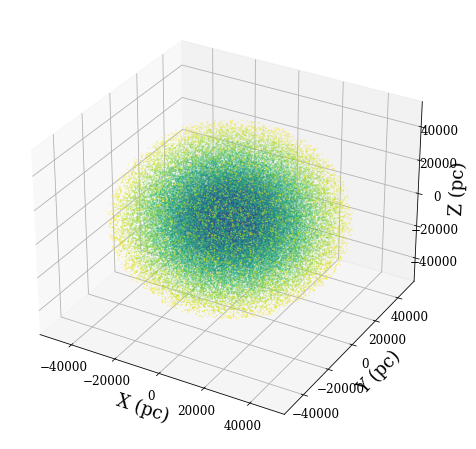

In [44]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mwHalo.cartesianPhaseSpacePoints[0],mwHalo.cartesianPhaseSpacePoints[1],mwHalo.cartesianPhaseSpacePoints[2],c=mwHalo.radii,s=.1)
ax.set_xlabel('X (pc)')
ax.set_ylabel('Y (pc)')
ax.set_zlabel('Z (pc)')

# Colored by radius, from dark blue to yellow

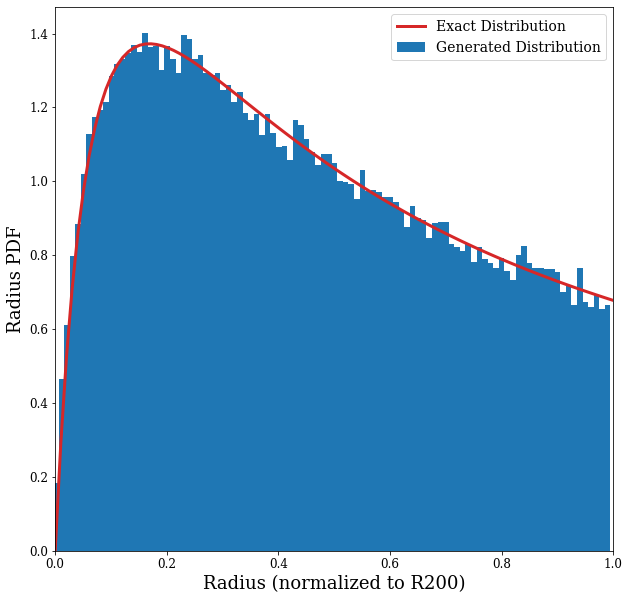

In [108]:
fig, ax1 = plt.subplots(figsize=(10,10))

steps = 100

color = 'tab:blue'
ax1.set_xlabel('Radius (normalized to R200)')
ax1.set_ylabel('Radius PDF')
x_vals, bins, p=ax1.hist(mwHalo.radiiNorm,steps,color=color,density=True,label="Generated Distribution",align='left')

color = 'tab:red'
r = np.linspace(0,1,steps)
pdf = []
for i in range(steps):
    pdf.append(mwHalo.radialPDF(r[i]))
ax1.plot(r,pdf, color=color,linewidth=3,label="Exact Distribution")
ax1.legend()
ax1.set_xlim(0,1)

plt.show()

Text(0.5, 0, 'Vz (km/s)')

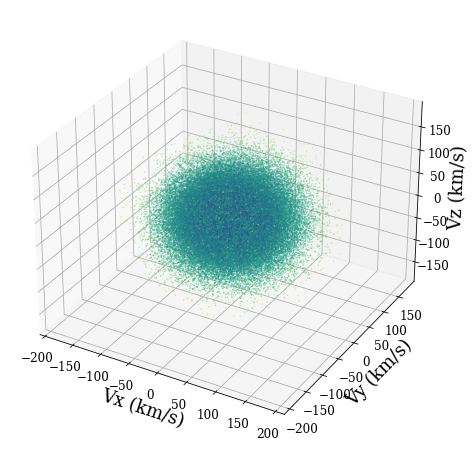

In [46]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mwHalo.cartesianPhaseSpacePoints[3],mwHalo.cartesianPhaseSpacePoints[4],mwHalo.cartesianPhaseSpacePoints[5],c=mwHalo.speeds,s=.1)
ax.set_xlabel('Vx (km/s)')
ax.set_ylabel('Vy (km/s)')
ax.set_zlabel('Vz (km/s)')

# Colored by speed, from dark blue to yellow

In [47]:
# This cell finds the speed probability distribution function integrated over all radii. It steps through speeds, integrating over the PDF values for
# that speed at each radii before moving on to the next one.

PDF_over_r = []
n=100
speeds = np.linspace(0,np.max(mwHalo.speeds),n)
for i in range(n):
    dispSquared = lambda normRad: mwHalo.radialVelocityDispersion(normRad)
    #CDF_over_r.append(integrate.quad(lambda normRad: special.erf(speed/np.sqrt(2*dispSquared(normRad)**2)) - np.sqrt(2/(np.pi*dispSquared(normRad)**2))*speed*np.exp(-speed**2/(2*dispSquared(normRad)**2)), 0, 1 )[0])
    PDF_over_r.append(integrate.quad(lambda normRad: (1/(2*np.pi*dispSquared(normRad)**2))**(3/2)*(4*np.pi*speeds[i]**2)*np.exp(-speeds[i]**2/(2*dispSquared(normRad)**2)),0,1)[0])

<ipython-input-5-ab4fef2df64c>:155: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integrate.quad(lambda y: self.gFcn(y)/(y**3*(1+y)**2), self.c*radiusNorm, np.inf)[0]
<ipython-input-5-ab4fef2df64c>:155: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrate.quad(lambda y: self.gFcn(y)/(y**3*(1+y)**2), self.c*radiusNorm, np.inf)[0]


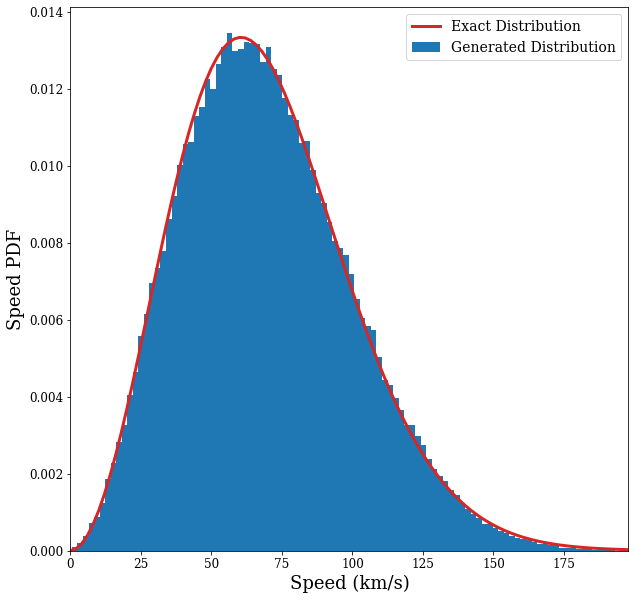

In [104]:
# Plotting the speed PDF integrated over all radii.

fig, ax1 = plt.subplots(figsize=(10,10))
color = 'tab:blue'
ax1.set_xlabel('Speed (km/s)')
ax1.set_ylabel('Speed PDF')
ax1.hist(mwHalo.speeds,100, color=color,density=True,label="Generated Distribution",align='left')

color = 'tab:red'
ax1.plot(speeds, PDF_over_r, color=color,linewidth=3,label="Exact Distribution")
ax1.legend()
ax1.set_xlim(0,np.max(mwHalo.speeds))

plt.show()

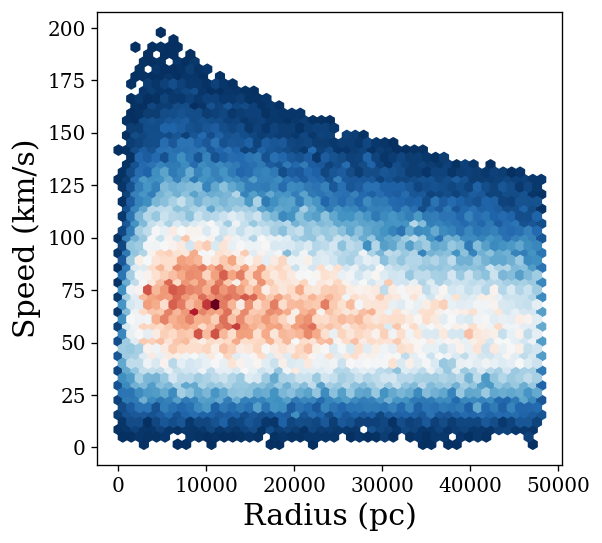

In [49]:
### Looking at a 2D histogram of speed and radius:
fig = plt.figure(figsize=(5, 5), dpi= 120)
plt.hexbin(
    mwHalo.radii, 
    mwHalo.speeds,
    mincnt=1,gridsize=50,cmap='RdBu_r'
)
plt.gca().set_xlabel("Radius (pc)")
plt.gca().set_ylabel("Speed (km/s)");

-0.0007689400073584738

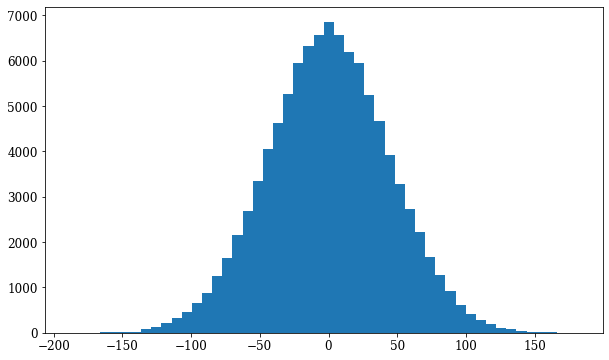

In [58]:
velVec = mwHalo.cartesianPhaseSpacePoints[3:6]
posVec = mwHalo.cartesianPhaseSpacePoints[0:3]
np.shape(posVec)
radVel = (velVec[0]*posVec[0] + velVec[1]*posVec[1] + velVec[2]*posVec[2])/mwHalo.radii
plt.hist(radVel,50)
np.mean(radVel)

44.08676968936369 -0.16845930903585796


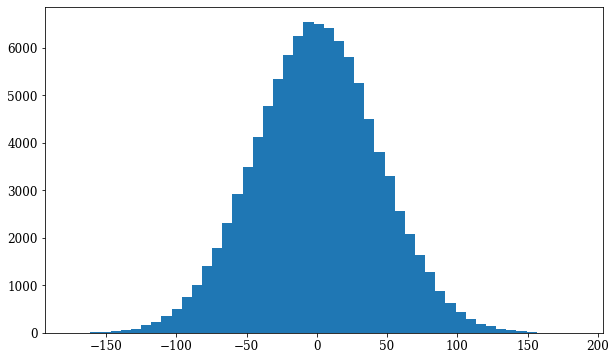

In [69]:
thetaUnitVec = np.array((posVec[0]*posVec[2],posVec[1]*posVec[2],-posVec[0]**2-posVec[1]**2)/(mwHalo.radii*np.sqrt(posVec[0]**2+posVec[1]**2)))
thetaVel = velVec[0]*thetaUnitVec[0] + velVec[1]*thetaUnitVec[1] + velVec[2]*thetaUnitVec[2]
plt.hist(thetaVel,50)
print(np.sqrt(np.mean(thetaVel**2)),np.mean(thetaVel))

44.24422677976528 0.07645576195130652


<ipython-input-73-d853bd097184>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  phiUnitVec = np.array((-posVec[1]/np.sqrt(posVec[0]**2+posVec[1]**2),posVec[0]/np.sqrt(posVec[0]**2+posVec[1]**2),0))


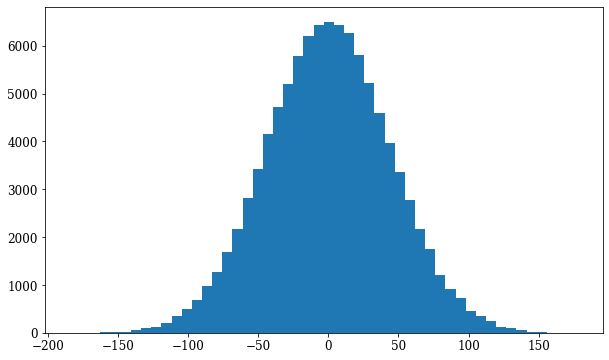

In [73]:
phiUnitVec = np.array((-posVec[1]/np.sqrt(posVec[0]**2+posVec[1]**2),posVec[0]/np.sqrt(posVec[0]**2+posVec[1]**2),0))
phiVec = velVec[0]*phiUnitVec[0] + velVec[1]*phiUnitVec[1] + velVec[2]*phiUnitVec[2]
plt.hist(phiVec,50)
print(np.sqrt(np.mean(phiVec**2)),np.mean(phiVec))

In [51]:
# Saving the generated halo so we can load it up in another file

import time, os

saveHalo = True

if saveHalo == True:
    t = time.localtime()
    timestamp = time.strftime('%b_%d_%Y_%H%M', t)
    
    metaLabels = np.array(('nTracers','rScale','mwHaloDensity','delta','criticalDensity'))
    metaInfo = np.array((nTracers,rScale,mwHaloDensity,delta,criticalDensity))
    phaseSpaceLabels = np.array(('x_pc','y_pc','z_pc','vx_km_s','vy_km_s','vz_km_s'))
    np.savez('generatedHalos//nfwGeneratedTracers_'+timestamp,metaLabels,metaInfo,phaseSpaceLabels,np.transpose(mwHalo.cartesianPhaseSpacePoints))

Random code snippets

In [16]:
np.shape(mwHalo.cartesianPhaseSpacePoints)

(6, 100000)

In [60]:
sigma = 2
f = lambda x: 1+special.erf(x)
bracket = (-20,20)

pdf = lambda x: (2/np.sqrt(np.pi))*np.exp(-x**2)
x_range = np.linspace(-2,2,100)

In [74]:
f = lambda x: x
bracket = (0,1)

pdf = lambda x: (x)**0
x_range = np.linspace(0,1,100)

In [97]:
samples = mwHalo.inverseTransformSampling(f,bracket,100000)

(array([ 13.,  48., 105., 202., 240., 196., 120.,  52.,  19.,   5.]),
 array([-0.02526235, -0.01975434, -0.01424632, -0.0087383 , -0.00323029,
         0.00227773,  0.00778575,  0.01329376,  0.01880178,  0.0243098 ,
         0.02981782]),
 <BarContainer object of 10 artists>)

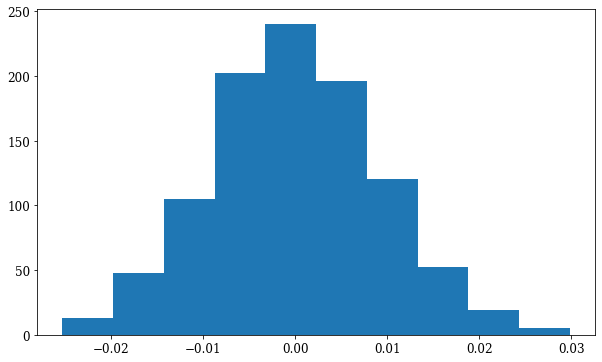

In [96]:
devlist=[]
for i in range(0,1000):
    samples =s mwHalo.inverseTransformSampling(f,bracket,1000)
    dev = np.mean(samples)-.5
    devlist.append(dev)
    
plt.hist(devlist)

In [91]:
pdf(x_range)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

50201.816745646654

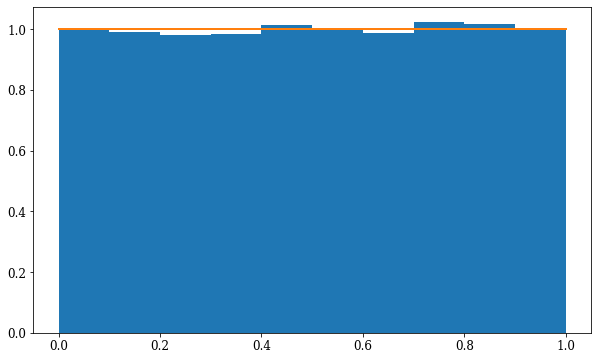

In [100]:
plt.hist(samples,10,density=True)
plt.plot(x_range,pdf(x_range))
np.sum(samples)

(array([100147., 100252., 100029., 100082.,  99564.,  99895., 100077.,
         99935.,  99680., 100339.]),
 array([9.00946701e-08, 9.99999596e-02, 1.99999829e-01, 2.99999699e-01,
        3.99999568e-01, 4.99999438e-01, 5.99999307e-01, 6.99999177e-01,
        7.99999046e-01, 8.99998916e-01, 9.99998785e-01]),
 <BarContainer object of 10 artists>)

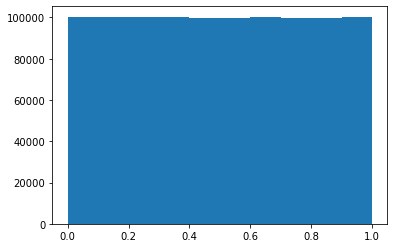

In [120]:
plt.hist(np.random.default_rng().uniform(0,1,1000000))